# Introduction to Neural Networks

In this lab, you will have your first contact with Neural Networks, and neural network training. We will use Pytorch to quickly deploy and train neural networks in different types of data, assess their performance and interpret their results.

## Preparation

To create our first neural network model, we are going to load the Pytorch library, which contains many of the necessary utilities to deploy and train neural network models. We also import `numpy`, a library that is useful for some numerical computations.

In [1]:
import torch
import numpy as np

The most basic `Pytorch` datatype is the tensor, which you can think of as a more general version of a matrix. `Pytorch` tensors are built to facilitate the computation of gradients, which will be useful when we train our neural network models.

Let us start by creating a simple random tensor and check some of its attributes.

In [2]:
t = torch.rand(3, 4) # Create a 3 x 4 tensor with random numbers

# Let's check the contents of t
print(t)

tensor([[0.8345, 0.7270, 0.7358, 0.4049],
        [0.2613, 0.0529, 0.5568, 0.9982],
        [0.4074, 0.9245, 0.7670, 0.0882]])


In [7]:
# Let's now check some properties of t
print('Shape of tensor:', t.shape)
print('Datatype of tensor:', t.dtype)
print('Device used to store tensor:', t.device)

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device used to store tensor: cuda:0


In [17]:
torch.device('cuda:0')

device(type='cuda', index=0)

In [18]:
# Let's now move our tensor to a GPU, if one is available
if torch.cuda.is_available():
    t = t.to('cuda')
    print('Device used to store tensor:', t.device)
    print('Device name:', torch.cuda.get_device_name(0))
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    device = torch.device('cuda:0')
else:
    print('No GPU available.')
    device = torch.device('cpu')
    
print(device)

Device used to store tensor: cuda:0
Device name: Quadro RTX 3000
Allocated: 0.0 GB
Cached:    0.0 GB
cuda:0


## Differentiation with `autograd`

Let's look at how Pytorch helps with keeping track of gradients. To that purpose, we will create two tensors, perform some operations on them, and check how these operations are tracked for the purpose of computing the gradients.

In [19]:
# We create two tensors with two elements each, and activate gradient tracking
a = torch.tensor([2., 3.], requires_grad=True).to(device)
b = torch.tensor([6., 4.], requires_grad=True).to(device)

print('a:', a)
print('b:', b)

a: tensor([2., 3.], device='cuda:0', grad_fn=<ToCopyBackward0>)
b: tensor([6., 4.], device='cuda:0', grad_fn=<ToCopyBackward0>)


Let's perform some computation using `a` and `b`. In particular, let us compute

$$c=3a^3-b^2$$

where the powers are computed elementwise. 

In [20]:
c = 3 * a ** 3 - b ** 2
print('c =', c)

c = tensor([-12.,  65.], device='cuda:0', grad_fn=<SubBackward0>)


We have that:

$$\frac{\partial c}{\partial a}=9a^2,$$

and

$$\frac{\partial c}{\partial b}=-2b.$$

When we call the method `.backward()` on `c`, `Autograd` calculates these gradients and stores them in the respective tensors' `.grad` attribute. For example, we can compute the sum of the elements in `c` and then backpropagate the gradient, to have:

In [ ]:
c.sum().backward()

grada = a.grad
gradb = b.grad

In [23]:
print('9 * a ** 2 =', 9 * a ** 2)
print('grad_a =', grada)

print('\n-2b =', -2 * b)
print('grad_b =', gradb)

9 * a ** 2 = tensor([36., 81.], device='cuda:0', grad_fn=<MulBackward0>)
grad_a = None

-2b = tensor([-12.,  -8.], device='cuda:0', grad_fn=<MulBackward0>)
grad_b = None


## Neural networks

We can now implement our first neural network. We will use the neural network to classify pieces of clothing in the well known Fashion-MNIST dataset. 

### Data

We start by loading the data to be used, for which we use the `torchvision` library.

In [24]:
# The library torchvision will be used to load the data
import torchvision

# The transforms module is used to convert the data into adequate Pytorch
# tensors.
import torchvision.transforms as transforms

In [25]:
# We import data for training and testing separately
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))

To facilitate the manipulation of the data, we create a **data loader**: an object that is used to get batches of data from the dataset during training. 

In [26]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

Let's visualize some of the samples in our dataset.

Image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([0, 3, 0, 7, 9, 4, 4, 6, 2, 5])


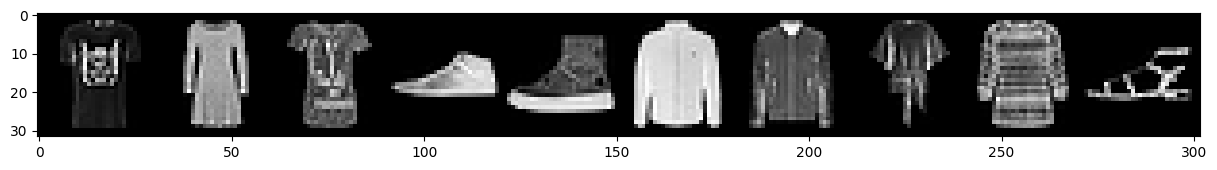

In [28]:
# Import plotting utilities
import matplotlib.pyplot as plt

# Get a sample from our dataloader. 
# The sample consists of a batch of images and corresponding labels.
images, labels = next(iter(data_loader))

# To plot the sample, we create a grid
plt.figure(figsize=(15, 10))
grid = torchvision.utils.make_grid(nrow=20, tensor=images)
print('Image tensor:', images.shape)
print('class labels:', labels)

# Plot the samples
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray')

Let's decode the previous output. The images in the sample are stored in a single tensor with dimensions 10 &times; 1 &times; 28 &times; 28. What this means is that the sample contains:

* 10 images;
* Each image has a single channel, since these are black & white images. Colored images would have 3 channels (RGB);
* Each image is 28 &times; 28 pixels.

The labels are encoded as numbers. For example, 5 stands for "sandal", 8 for "bag", 7 for "sneaker", etc. The complete correspondence is summarized in the next table.

| Label   |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 
| ------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Object  | T-shirt | Trousers | Pull-over | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Boot |

In [29]:
LABELS = ('T-shirt', 'Trousers', 'Pull-over', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot')

### Creating a neural network

We will now create a simple neural network. We use the `nn` module of Pytorch and create a new class corresponding to the neural network. In this class, we should specify the `__init__` method, and the `forward` method, which computes the output for a given input.

In [30]:
import torch.nn as nn

# We create a new class "FeedForwardNetwork" from nn.Module
class FeedForwardNetwork(nn.Module):
    def __init__(self):
        # Call the super class constructor
        super().__init__()

        # Our network will have a single hidden layer with 100 units
        self.layers = nn.Sequential(
            nn.Flatten(),        # Convert 28 x 28 images into a flat tensor
            nn.Linear(784, 100), # 28 x 28 = 784 inputs; 100 outputs
            nn.ReLU(),           # Add ReLU activation
            nn.Linear(100, 10)   # 100 inputs; 10 outputs (10 classes)
        )

    def forward(self, x): # implements the forward method (flow of tensors)
        # Given input x, we just run x through the layers in the network
        out = self.layers(x)
        return out

We can see how the (untrained) network classifies the examples in the sample. As expected, the classification is completely meaningless.

In [32]:
# Create an instance of the network
net = FeedForwardNetwork().to(device)

# Run the sample through the network
output = net(images.to(device))

# Let's check the classification
for i in range(output.shape[0]):
    y_est = torch.argmax(output[i, :])
    y_opt = labels[i]
    print('\nImage %i:' % i)
    print('\tEstimated label:', LABELS[y_est])
    print('\tCorrect label:', LABELS[y_opt])


Image 0:
	Estimated label: Shirt
	Correct label: T-shirt

Image 1:
	Estimated label: Shirt
	Correct label: Dress

Image 2:
	Estimated label: Shirt
	Correct label: T-shirt

Image 3:
	Estimated label: Shirt
	Correct label: Sneaker

Image 4:
	Estimated label: Shirt
	Correct label: Boot

Image 5:
	Estimated label: Shirt
	Correct label: Coat

Image 6:
	Estimated label: Shirt
	Correct label: Coat

Image 7:
	Estimated label: Shirt
	Correct label: Shirt

Image 8:
	Estimated label: Shirt
	Correct label: Pull-over

Image 9:
	Estimated label: Shirt
	Correct label: Sandal


## Training the network

Let us now train the network we just created. The first thing to do is to specify how to measure the performance of our network, and then optimize the parameters of our network with respect to the defined performance measure. 

As performance criterion, we will use the _cross-entropy loss_, which measures the negative log-likelihood of the data according to the neural network. By adjusting the parameters of the network to minimize this loss, we are implicitly optimizing the network to make the observed labels in the dataset as likely as possible.

In [33]:
loss = nn.CrossEntropyLoss()

We now proceed with the training of the network. We will train the network for 20 epochs using stochastic gradient descent with a learning rate of 0.01. To fetch the data from the dataset we use the previously created data loader. However, since we've already extracted a sample (batch), we start by resetting it.

In [35]:
EPOCHS = 20

# Define the optimizer. We indicate:
#   - What is being optimized (the parameters of the network)
#   - The learning rate 
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# Reset data loader
iter(data_loader)

for ep in range(EPOCHS):
    print('Training epoch:', ep)

    # Keep track of the loss during training
    train_loss = []

    # We use our data loader to fetch batches from our dataset
    for Xbatch, ybatch in data_loader:
        Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)
        # We first zero-out the gradients
        optimizer.zero_grad()

        # Compute output
        output = net(Xbatch)

        # Get loss
        l = loss(output, ybatch)

        # Compute gradients
        l.backward()

        # Perform optimization step
        optimizer.step()

        train_loss.append(l)

    print('Training loss: %.4f' % torch.tensor(train_loss).mean().item())

Training epoch: 0
Training loss: 1.3728
Training epoch: 1
Training loss: 0.7749
Training epoch: 2
Training loss: 0.6550
Training epoch: 3
Training loss: 0.5927
Training epoch: 4
Training loss: 0.5541
Training epoch: 5
Training loss: 0.5278
Training epoch: 6
Training loss: 0.5078
Training epoch: 7
Training loss: 0.4934
Training epoch: 8
Training loss: 0.4814
Training epoch: 9
Training loss: 0.4715
Training epoch: 10
Training loss: 0.4633
Training epoch: 11
Training loss: 0.4563
Training epoch: 12
Training loss: 0.4497
Training epoch: 13
Training loss: 0.4442
Training epoch: 14
Training loss: 0.4389
Training epoch: 15
Training loss: 0.4346
Training epoch: 16
Training loss: 0.4305
Training epoch: 17
Training loss: 0.4265
Training epoch: 18
Training loss: 0.4226
Training epoch: 19
Training loss: 0.4192


Let us now check how the trained network classifies the examples in our original sample.

In [38]:
# Run the sample through the network
output = net(images.to(device))

# Let's check the classification
for i in range(output.shape[0]):
    y_est = torch.argmax(output[i, :])
    y_opt = labels[i]
    print('\nImage %i:' % i)
    print('\tEstimated label:', LABELS[y_est])
    print('\tCorrect label:', LABELS[y_opt])


Image 0:
	Estimated label: T-shirt
	Correct label: T-shirt

Image 1:
	Estimated label: Dress
	Correct label: Dress

Image 2:
	Estimated label: T-shirt
	Correct label: T-shirt

Image 3:
	Estimated label: Sneaker
	Correct label: Sneaker

Image 4:
	Estimated label: Boot
	Correct label: Boot

Image 5:
	Estimated label: Coat
	Correct label: Coat

Image 6:
	Estimated label: Shirt
	Correct label: Coat

Image 7:
	Estimated label: Shirt
	Correct label: Shirt

Image 8:
	Estimated label: Shirt
	Correct label: Pull-over

Image 9:
	Estimated label: Sandal
	Correct label: Sandal


## Evaluate the network

We now use the test set that was kept aside to determine the performance of the network on unseen data. We create a simple function that receives a network and a dataset and computes the predictions for that dataset.

In [60]:
@torch.no_grad() # We don't need gradients for this
def get_predictions(network, dataset):

    # Create dataloader from dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000)

    # Create a tensor to store results
    predictions = torch.tensor([])
    for Xbatch, _ in dataloader:
        # Get predictions
        output = network(Xbatch.to(device))

        # Add them to the tensor
        # NOTE: 
        predictions = torch.cat((predictions, output.cpu()), dim=0)
        
    return predictions

In [61]:
# Import function to compute confusion matrix
from sklearn.metrics import confusion_matrix

# We compute the confusion matrix for the training set
predictions = get_predictions(net, train_set)
cm_train = confusion_matrix(y_true=train_set.targets, y_pred=predictions.argmax(1))

print('\n= Confusion matrix in training =')
print(cm_train)

print('\nTraining accuracy:', cm_train.trace() / predictions.shape[0])

# We compute the confusion matrix for the test set
predictions = get_predictions(net, test_set)
cm_test = confusion_matrix(y_true=test_set.targets, y_pred=predictions.argmax(1))

print('\n= Confusion matrix in test =')
print(cm_test)

print('\nTest accuracy:', cm_test.trace() / predictions.shape[0])


= Confusion matrix in training =
[[4739   28   98  317   24    7  713    0   73    1]
 [   9 5767   32  143   20    1   24    0    4    0]
 [  42   14 4291   54  960    6  574    0   59    0]
 [ 180   62   57 5251  244    0  185    0   21    0]
 [   7    3  332  163 5012    0  452    0   30    1]
 [   5    0    0    4    0 5578    1  242   38  132]
 [ 658   19  570  170  666    0 3807    1  108    1]
 [   0    0    0    0    0  198    0 5534   13  255]
 [  13    5   24   43   28   33  110   32 5707    5]
 [   1    1    0    3    0   80    1  214    7 5693]]

Training accuracy: 0.8563166666666666

= Confusion matrix in test =
[[768   4  15  53   7   1 135   0  17   0]
 [  4 953   4  27   6   0   4   0   2   0]
 [ 11   4 687  11 177   1  96   0  13   0]
 [ 21   9  14 863  38   1  50   0   4   0]
 [  0   1  65  31 807   1  88   0   7   0]
 [  0   0   0   1   0 910   0  52   4  33]
 [113   1 106  41 124   1 583   0  31   0]
 [  0   0   0   0   0  34   0 919   0  47]
 [  0   1   8   8   4 

# Activities

1. Verify the impact of L2 regularization in the performance of the network. To that purpose, repeat the training of the network, but add to the SGD parameters the option `weight_decay=0.1`.

2. Verify the impact of dropout in the performance of the network. To that purpose, repeat the training of the network, but add a dropout layer after the ReLU in the network definition. You can do it by adding the line `nn.Dropout(0.3),` (the number is the dropout probability).

3. From your results, do you believe that the original model is overfitting?